In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import vice
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z, AGB_MODELS
from yields import y_c_agb
import yields
import scipy
from plotting import fig_saver
import pandas as pd

In [16]:
sf = fig_saver("figures/")

Text(0.5, 1.0, 'Fractional contribution to metallicity')

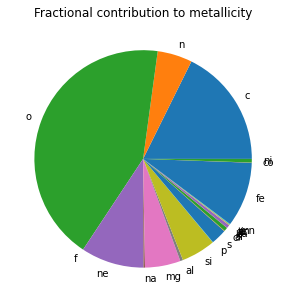

In [20]:
plt.figure(figsize=(10,5))
names = vice.solar_z.keys()[1:24]
values = [vice.solar_z(name)/0.01335 for name in names]
plt.pie(values, labels=names);
plt.title("Fractional contribution to metallicity")

# AGB Modle Parameters Comparison

# AGB Carbon Yields

In [13]:
def plot_c_table(study = "cristallo11", **kwargs):
    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    cmap = plt.get_cmap('jet')
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]

        plt.plot(m1, y, label=f"Z = {z}", c=cmap(i/N), **kwargs)

    plt.xlabel("stellar mass")
    plt.ylabel("$y_C^{agb}$")
    # plt.legend()
    plt.title(study)

In [14]:
def plot_weighted_c_yields(study = "cristallo11", Z = 0.014):
    interpolator = vice.yields.agb.interpolator("c", study=study)
    
    masses = interpolator.masses
    y = [interpolator(m, Z) for m in masses]
    
    plt.plot(masses, np.array(y)*np.array(masses)**-1.3, label=study)

    plt.xlabel("stellar mass")
    plt.ylabel("$y_C^{agb}$")
    plt.legend()

In [3]:
from dataclasses import dataclass
@dataclass
class agb_model:
    mass: float
    delta_t: float
    T_bcd: float
    N_p: int

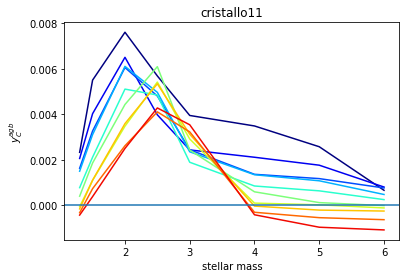

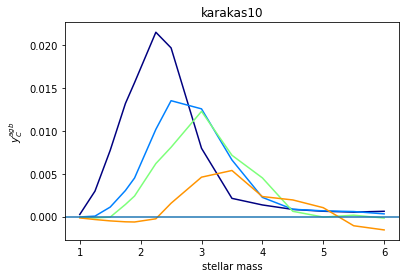

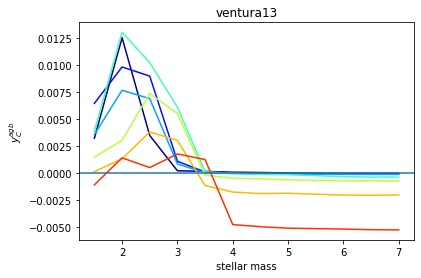

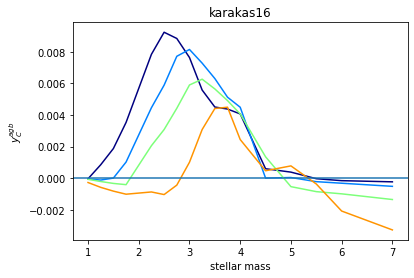

In [8]:
for study in AGB_MODELS:
    plot_c_table(study)
    plt.axhline(0)
    sf("yields_C_agb_to_mass_" + study)
    
    plt.show()
    

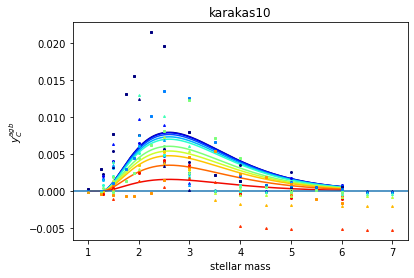

In [9]:
Z_vals = [0.0001,0.0003,0.001,0.002,0.003,0.006, 0.008, 0.01, 0.014, 0.02]
cmap = plt.get_cmap("jet")
for i in range(len(Z_vals)):
    Z = Z_vals[i]
    x = np.linspace(1, 6, 1000)
    y = y_c_agb()(x, Z)
    plt.plot(x, y, label=Z, c=cmap(i/len(Z_vals)))
plt.axhline(0)
plot_c_table("cristallo11", marker="o", ms=2, lw=0)
plot_c_table("ventura13", marker="^", ms=2, lw=0)
plot_c_table("karakas10", marker="s", ms=2, lw=0)
plot_c_table("karakas10", marker="+", ms=2, lw=0)

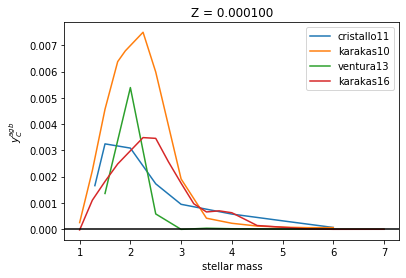

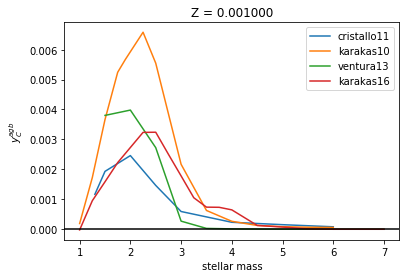

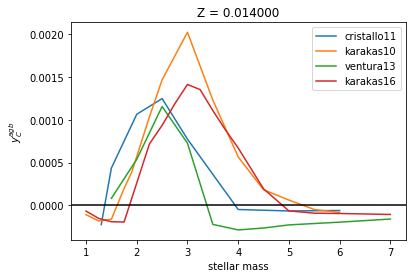

In [17]:
for Z in [0.0001, 0.001, 0.014]:
    for study in AGB_MODELS:
        plot_weighted_c_yields(study, Z=Z)

    plt.axhline(0, c="black")
    plt.title("Z = %f" % Z)

    sf("weighted_yields_C_agb_to_mass_logZ%i" % (np.log10(Z)))
    #x = np.linspace(1, 6)
    #y = y_c_agb(m0=2.6)(x, Z)*x**-1.3
    #plt.plot(x, y, c="black")
    #plt.ylim(-0.002, 0.008)
    #plt.show()
    

# CCSNE Carbon Yields

In [7]:
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    "CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    "CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }
allowed_rotations = {
    "LC18": [0, 150, 300],
    "S16/N20": [0],
    "CL13": [0, 300],
    "NKT13": [0],
    "CL04": [0],
    "WW95": [0]
}

ccsne_studies = ["LC18", "S16/N20", "CL13","CL04","WW95","NKT13"]
cmap = plt.get_cmap("jet")
N = len(ccsne_studies)

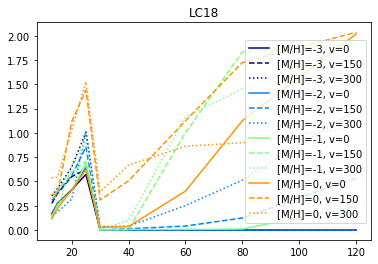

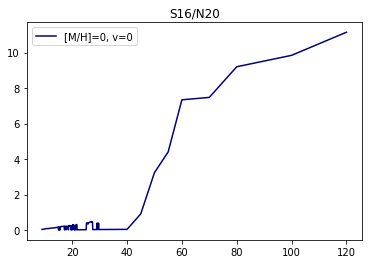

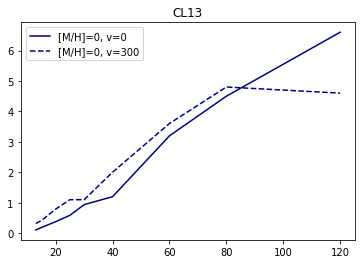

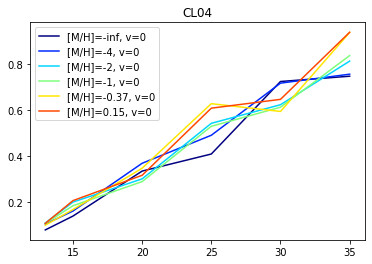

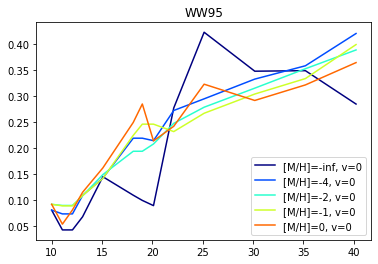

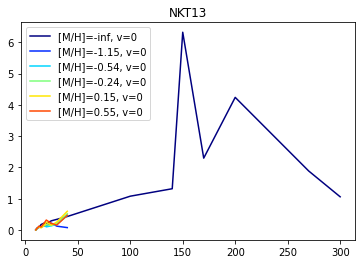

In [8]:
for study in ccsne_studies:
    metalicities = allowed_MoverH[study]
    
    N = len(metalicities)
    rotations = allowed_rotations[study]
    for i in range(N):
        for j in range(len(rotations)):
            rotation = rotations[j]
            MoverH = metalicities[i]
            table = vice.yields.ccsne.table("c", study=study, MoverH=MoverH, rotation=rotation)
            masses = table.masses
            m_yields = [table[mass] for mass in masses]

            plt.plot(masses, m_yields, label=f"[M/H]={MoverH}, v={rotation}", color=cmap(i/N), linestyle=["-", "--", ":"][j])
        
    plt.title(study)
    plt.legend()
    
    # sf("yields_C_ccsne_to_mass_" + study.replace("/", ""))
    plt.show()

<ipython-input-10-fb4005dc9381>:8: ScienceWarning: Supernovae yields from the Chieffi & Limongi (2004), ApJ, 608, 405 study are sampled on a grid of stellar masses up to 35 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-10-fb4005dc9381>:8: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-10-fb4005dc9381>:8: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractio

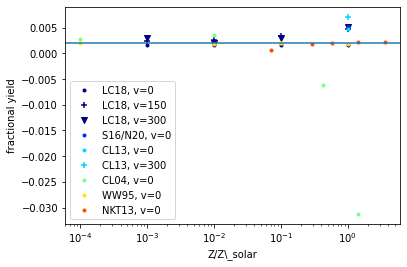

In [10]:
for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        plt.scatter(Z, y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=[".", "+", "v"][j])

plt.legend()
plt.axhline(0.002)
plt.xscale("log")
#plt.ylim([0, 0.008])
plt.xlabel("Z/Z\_solar")
plt.ylabel("fractional yield")
sf("CCSN_C_yields_to_Z")


# AGB Single Stellar Population Yields

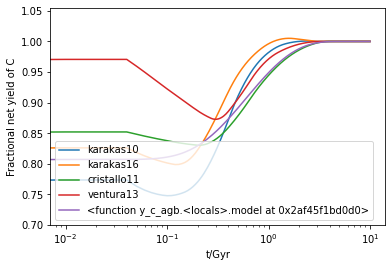

In [52]:
for model in ["karakas10", "karakas16", "cristallo11", "ventura13", y_c_agb()]:
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014)
    plt.plot(times, np.array(m_c)/m_c[-1], label=model)
plt.xlabel("t/Gyr")
plt.ylabel("Fractional net yield of C")
plt.xscale("log")
plt.legend()
plt.ylim(0.7)
sf("y_C_agb_to_t")


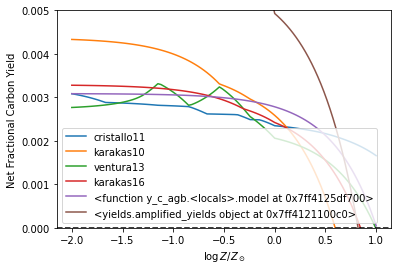

In [11]:
for model in ["cristallo11", "karakas10","ventura13", "karakas16", y_c_agb(alpha=20), yields.amplified_yields("c", prefactor=10)]:
    vice.yields.agb.settings["c"] = model
    Zs = 0.014*10**np.linspace(-2, 1, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    
    plt.plot(np.log10(Zs/0.014), np.array(mass_yields)/1e6, label=model)
    

plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel("Net Fractional Carbon Yield")
plt.ylim(-0e-3, 5e-3)
plt.axhline(0, c="black", linestyle="--")

plt.legend()
sf("y_C_AGB_to_Z")




In [54]:
yields

[0.0,
 0.11774810000000001,
 0.09326292,
 0.2191149,
 0.3161153,
 0.2051313,
 0.1559376,
 0.4670457]

<ipython-input-12-8b8f0b70d764>:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(lambda x: x**-2.3 * interpolator(x, Z), 1, 8)[0]
<ipython-input-12-8b8f0b70d764>:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the su

Text(0, 0.5, 'Z_C_eq')

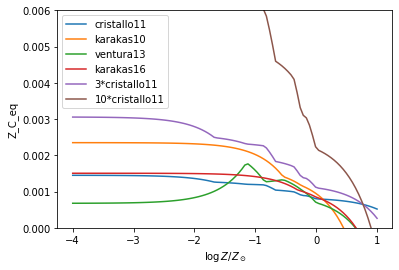

In [12]:

for study in AGB_MODELS:
    def equilibrium_Z_C(Z):
        interpolator = vice.yields.agb.interpolator("c", study=study)
        return scipy.integrate.quad(lambda x: x**-2.3 * interpolator(x, Z), 1, 8)[0]
    log_Z = np.linspace(-4, 1, 100)
    y = [(0.002 + equilibrium_Z_C(0.014*10**z))/(1+2.5-0.4) for z in log_Z]
    plt.plot(log_Z, y, label=study)
    
def equilibrium_Z_C(Z):
    interpolator = yields.amplified_yields("c", prefactor=3)
    return scipy.integrate.quad(lambda x: x**-2.3 * interpolator(x, Z), 1, 8)[0]
log_Z = np.linspace(-4, 1, 100)
y = [(0.002 + equilibrium_Z_C(0.014*10**z))/(1+2.5-0.4) for z in log_Z]
plt.plot(log_Z, y, label="3*cristallo11")    

def equilibrium_Z_C(Z):
    interpolator = yields.amplified_yields("c", prefactor=10)
    return scipy.integrate.quad(lambda x: x**-2.3 * interpolator(x, Z), 1, 8)[0]
log_Z = np.linspace(-4, 1, 100)
y = [(0.002 + equilibrium_Z_C(0.014*10**z))/(1+2.5-0.4) for z in log_Z]
plt.plot(log_Z, y, label="10*cristallo11")   
    
plt.legend()
plt.ylim(0, 0.006)
plt.xlabel("$\log Z/Z_\odot$")
plt.ylabel("Z_C_eq")


In [178]:
vice.solar_z("c")

0.00236

<function matplotlib.pyplot.legend(*args, **kwargs)>

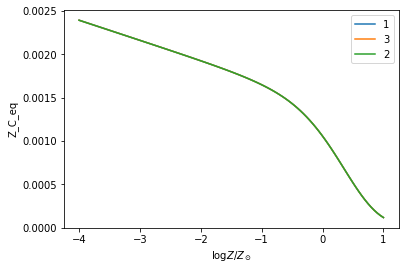

In [118]:
for q in [1, 3, 2]:
    def equilibrium_Z_C(Z):
        return scipy.integrate.quad(lambda x: x**-2.3 * y_c_agb()(x, Z), 1, 8)[0]
    log_Z = np.linspace(-4, 1, 100)
    y = [(0.002 + equilibrium_Z_C(0.014*10**z))/(1+2.5-0.4) for z in log_Z]
    plt.plot(log_Z, y, label=q)
plt.legend()
plt.ylim(0)
plt.xlabel("$\log Z/Z_\odot$")
plt.ylabel("Z_C_eq")
plt.legend

# Investigation of ratio of CCSNe to AGB for carbon production


In [13]:
def IMF(m):
    """The Initial Mass Function
    Returns the PDF of a star born with some mass M"""
    norm = 1/3.9
    if m > 0.5:
        return norm * m**-2.3
    elif m > 0.08:
        return norm * m**-1.3
    else:
        return norm * m**-0.3

def m_rem(m):
    """The remenant mass of a star mass m
    Returns the mass of the stellar remanent for a star of mass m"""
    if m >= 8:
        return 1.44
    else:
        return 0.394 + 0.109*m

def integrated_yield(model, Z, m_min=1, m_max = 7):
    if type(model) == str:
        f = vice.yields.agb.interpolator("c", study=model)
    else:
        f = model
    
    return scipy.integrate.quad(lambda m: f(m, Z)* IMF(m) * (m-m_rem(m)), m_min, m_max)[0] 

def Z_eq_c(model, Z):
    if type(model) == str:
        f = vice.yields.agb.interpolator("c", study=model)
    else:
        f = model
    eta = 2.5
    r = 0.4
    return (vice.yields.ccsne.settings("c") + scipy.integrate.quad(lambda m: f(m, Z)* IMF(m)*m, m_min, m_max)[0] )/(1 + eta - r)
    

def calculate_equilibrium_yield(model, Z):
    eta = 2.5
    r = 0.4
    return (integrated_yield(model, Z) + vice.yields.ccsne.settings["c"]) / (1 + eta - r)

In [14]:
calculate_equilibrium_yield(lambda m, z:0, 0.01)
vice.yields.ccsne.settings["c"] = 0.002
vice.yields.ccsne.settings["o"] = 0.015

In [15]:
# calculation of equilibrium ccsne yields for [c/o]
np.log10(2*vice.yields.ccsne.settings["c"]/vice.yields.ccsne.settings["o"]) - np.log10(vice.solar_z['c'] / vice.solar_z['o'])

-0.1895472419048012

In [16]:
# from Asplund+09
Z_c_solar = 0.74 * 10**(-12+ 8.43)
Z_o_solar = 0.74 * 10**(-12+8.69)

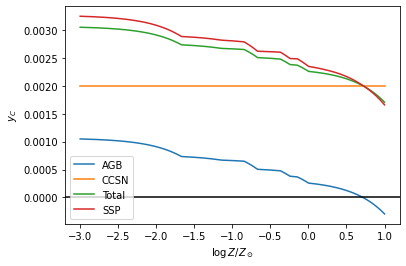

In [17]:
Zs = 0.014 * 10**np.linspace(-3,1, 1000)
y = [integrated_yield("cristallo11", Z) for Z in Zs]
log_Z = np.log10(Zs/0.014)
plt.plot(log_Z, y, label="AGB")
plt.plot(log_Z, [0.002]*len(Zs), label="CCSN")
plt.plot(log_Z, np.array(y) + 0.002, label="Total")
plt.xlabel("$\log Z/Z_\odot$")
plt.ylabel("$y_C$")

vice.yields.agb.settings["c"] = "cristallo11"
vice.yields.ccsne.settings["c"] = 0.002

mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])

plt.plot(log_Z, np.array(mass_yields)/1e6, label="SSP")



plt.axhline(0, c="black")

plt.legend()

<ipython-input-13-25318056036e>:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(lambda m: f(m, Z)* IMF(m) * (m-m_rem(m)), m_min, m_max)[0]
<ipython-input-13-25318056036e>:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 

(-0.5, 0.5)

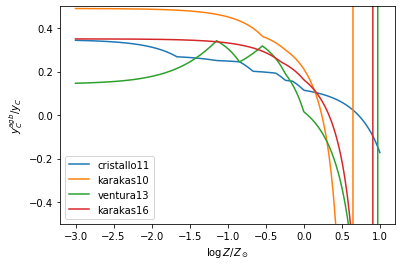

In [18]:
Zs = 0.014 * 10**np.linspace(-3,1, 1000)
log_Z = np.log10(Zs/0.014)


for model in AGB_MODELS:
    y = np.array([integrated_yield(model, Z) for Z in Zs])

    plt.plot(log_Z, y/(y+0.002), label=model)

plt.xlabel("$\log Z/Z_\odot$")
plt.ylabel("$y_C^{agb}/y_C$")
plt.legend()

plt.ylim(-0.5, 0.5)